# 2 - Preprocesamiento del dataset.

Este notebook está dedicado al preprocesamiento de los datos de fMRI con el objetivo de prepararlos para su posterior uso como entrada en los modelos de deep learning.

Como indican Jaber et al. (2019), no existe un consenso estricto sobre las tareas que deben realizarse en la etapa de preprocesamiento, ya que estas tienen distintos efectos sobre los datos de fMRI. A pesar de ello, algunas de las más comunes incluyen la corrección del tiempo de adquisición de cortes (*slice timing correction*), la realineación (*motion correction*) y el suavizado espacial (*smoothing*), entre otras.

El estudio de Bezmaternykh et al. (2021), del cual se obtuvo el conjunto de datos, implementó las siguientes tareas de preprocesamiento con SPM12 en MATLAB:

- Eliminación de los primeros 5 volúmenes temporales.
- Corrección de movimiento.
- Corrección de desfase temporal entre cortes.
- Normalización a espacio MNI con voxelado de 2x2x2 mm.
- Suavizado con un kernel gaussiano de 8 mm FWHM.

En el presente proyecto se ha optado por desarrollar modelos 2D en lugar de utilizar volúmenes 3D completos (formados por 25 cortes axiales) por dos razones principales. Primero, debido a las restricciones computacionales presentes en el proyecto. Segundo, debido a que los modelos preentrenados que se implementarán en la fase de *transfer learning* requieren que sus datos de entrada estén en 2D. El desarrollo de modelos 2D es una práctica habitual en estudios de neuroimagen por las mismas razones indicadas anteriormente, menor coste computacional y disponibilidad de modelos preentrenados en 2D (Bernal et al., 2019). Cabe destacar que estos modelos 2D pierden importante información espacial, lo cual es de gran importancia teniendo en cuenta el grán número de interconexiones entre diferentes estructuras cerebrales. A pesar de ello diferentes estudios sugieren que los modelos en 2D ofrecen igualmente resultados precisos y fiables (Avesta et al., 2023).

También existen modelos denominados 2.5D los cuales se basan en introducir un mayor número de slices 2D en diferentes canales del modelo. Esta metodología también se implementará.

Por lo tanto, dado que el enfoque adoptado en este estudio se basa en el análisis secuencial de un único corte axial por participante (el slice con mayor varianza) no se aplicará la corrección por tiempo de adquisición de cortes del estudio original ya que este procedimiento está diseñado para alinear temporalmente múltiples cortes dentro de un volumen, lo cual no aplica al tratarse de un único corte. Además, tampoco se aplicará suavizado espacial ya que el suavizado tridimensional implicaría la introducción de información de cortes adyacentes que no se utilizan en el modelo y el suavizado bidimensional podría diluir detalles espaciales relevantes para el aprendizaje automático. Teniendo esto en cuenta y los resultados obtenidos en la fase de exploración de datos, las tareas de preprocesado que se llevarán a cabo en el presente proyecto incluyen las siguientes:

- **Recorte de volúmenes iniciales:** eliminación de los primeros volúmenes de cada sujeto que suelen contener artefactos producidos por la estabilización del escáner o movimientos del participante.
- **Aplicación de máscara cerebral:** exclusión de voxeles fuera del cerebro (hueso, aire, fondo), conservando únicamente la señal funcional cerebral.
- **Normalización z-score:** estandarización de intensidades por voxel para homogeneizar la señal entre sujetos y regiones.
- **Conversión a float32:** reducción del tamaño en memoria sin pérdida significativa de precisión, optimizando el rendimiento del entrenamiento.
- **Selección de un único slice:** selección del slice con la mayor varianza.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = "/content/drive/MyDrive/Diagnóstico Depresión RM (Deep Learning Híbrido)/data/raw/"

In [ ]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
!pip install nilearn
from nilearn.masking import compute_epi_mask

In [ ]:
base_dir = "/content/drive/MyDrive/Máster/Diagnóstico Depresión RM (Deep Learning Híbrido)"
data_dir = os.path.join(base_dir, "data/raw")
output_X_path = os.path.join(base_dir, "data/splits/X_processed.npy")
output_y_path = os.path.join(base_dir, "data/splits/y_processed.npy")
metadata_path = os.path.join(base_dir, "data/participants.tsv")
save_mask_dir= os.path.join(base_dir, "data/preprocessed/masks")

## 2.1 - Recorte de volúmenes iniciales.

Se eliminan los primeros volúmenes de cada sujeto ya que suelen contener artefactos producidos por la estabilización del escáner o movimientos del participante.

In [ ]:
def load_and_crop_volumes(file_path, discard_volumes=5):
    """
    Carga un volumen fMRI desde archivo y elimina los primeros volúmenes especificados.

    Esta función abre un archivo `.nii.gz`, obtiene los datos en formato numpy y elimina
    los primeros volúmenes temporales, que suelen contener ruido de estabilización.

    Parameters
    ----------
    file_path : str
        Ruta al archivo NIfTI que contiene el volumen fMRI.
    discard_volumes : int, optional
        Número de volúmenes iniciales a descartar. Por defecto 5.

    Returns
    -------
    np.ndarray or None
        Array 4D con los volúmenes recortados, o `None` si el volumen es demasiado corto.
    """
    img = nib.load(file_path)
    data = img.get_fdata()
    if data.shape[3] <= discard_volumes:
        return None
    return data[..., discard_volumes:]

## 2.2 - Obtención de máscara cerebral.
Se aplica una máscara cerebral para excluir los voxeles fuera del cerebro (hueso, aire, fondo), conservando únicamente la señal funcional cerebral.

In [ ]:
def compute_brain_mask(mean_img_3d):
    """
    Genera una máscara cerebral booleana a partir de una imagen 3D media.

    Utiliza la función `compute_epi_mask` de Nilearn para estimar automáticamente
    qué voxeles pertenecen al cerebro. La imagen debe representar la media temporal
    de un volumen fMRI.

    Parameters
    ----------
    mean_img_3d : np.ndarray
        Imagen 3D (sin dimensión temporal) que representa el promedio de un volumen fMRI.

    Returns
    -------
    np.ndarray
        Máscara booleana con la misma forma que `mean_img_3d`, donde `True` indica regiones cerebrales.
    """
    mean_nifti = nib.Nifti1Image(mean_img_3d, affine=np.eye(4))
    mask_img = compute_epi_mask(mean_nifti)
    return mask_img.get_fdata().astype(bool)

## 2.3 - Reconstrucción del volumen cerebral.


In [ ]:
def reconstruct_volume(masked_data, mask):
    """
    Reconstruye un volumen 4D a partir de datos enmascarados y una máscara booleana.

    Esta función toma los datos fMRI comprimidos (solo dentro del cerebro) y los
    reubica en su forma espacial original utilizando la máscara. El resultado es
    un volumen 4D con forma (X, Y, Z, T).

    Parameters
    ----------
    masked_data : np.ndarray
        Array 2D con forma (T, N), donde N es el número de voxeles dentro de la máscara.
    mask : np.ndarray
        Máscara booleana 3D que indica qué voxeles están dentro del cerebro.

    Returns
    -------
    volume_4d : np.ndarray
        Volumen reconstruido con forma (X, Y, Z, T).
    """
    T = masked_data.shape[0]
    vol_shape = mask.shape + (T,)
    volume_4d = np.zeros(vol_shape, dtype=np.float32)
    volume_4d[mask] = masked_data.T
    return volume_4d

## 2.4 - Selección del *slice* con mayor varianza.

In [ ]:
def select_high_variance_slice(volume_4d):
    """
    Selecciona el corte axial (eje Z) con mayor varianza temporal en un volumen fMRI 4D.

    Esta función calcula la varianza a lo largo del tiempo para cada plano axial
    y devuelve el índice del corte con mayor variabilidad. Se asume que ese plano
    contiene mayor información útil para tareas de clasificación.

    Parameters
    ----------
    volume_4d : np.ndarray
        Volumen fMRI con forma (X, Y, Z, T), donde T es el número de pasos temporales.

    Returns
    -------
    int
        Índice Z del corte con mayor varianza temporal.
    """
    variances = [np.var(volume_4d[:, :, z, :]) for z in range(volume_4d.shape[2])]
    return int(np.argmax(variances))

## 2.5 - Normalización.

Se estandarizan las intensidades por voxel para homogeneizar la señal entre sujetos y regiones.

In [ ]:
def normalize_zscore_2d(slice_2d):
    """
    Normaliza una imagen 2D utilizando Z-score.

    La función transforma los valores del corte restando la media y dividiendo por la desviación estándar.
    Si la desviación estándar es cero, solo se resta la media para evitar divisiones inválidas.

    Parameters
    ----------
    slice_2d : np.ndarray
        Imagen 2D (X, Y) a normalizar.

    Returns
    -------
    np.ndarray
        Imagen normalizada con media 0 y desviación estándar 1 (si std ≠ 0).
    """
    mean = np.mean(slice_2d)
    std = np.std(slice_2d)
    return (slice_2d - mean) / std if std != 0 else slice_2d - mean

## 2.6 - *Pipeline* de procesamiento de datos.
Se desarrolla una función para aplicar todas las tareas de preprocesamiento sobre los datos.

In [ ]:
def preprocess_all_subjects(data_dir, output_X_path, output_y_path, metadata_path, save_mask_dir=None, discard_volumes=5):
    """
    Preprocesa los datos fMRI de todos los sujetos de un directorio y genera secuencias 2D normalizadas.

    Para cada sujeto, se carga el volumen fMRI, se descartan los primeros volúmenes, se calcula la máscara cerebral,
    se reconstruye el volumen completo y se selecciona el corte axial con mayor varianza. Luego, se extrae la
    secuencia temporal de ese corte, se normaliza con Z-score y se guarda el resultado con dtype float32.

    Parameters
    ----------
    data_dir : str
        Ruta al directorio que contiene los archivos `.nii.gz` de los sujetos.
    output_X_path : str
        Ruta donde se guardará el array `X_processed` con las secuencias normalizadas.
    output_y_path : str
        Ruta donde se guardarán las etiquetas `y_processed`.
    metadata_path : str
        Ruta al archivo `.tsv` que contiene los metadatos con los grupos (control o deprimido).
    save_mask_dir : str, optional
        Si se especifica, guarda la máscara de cerebro de cada sujeto en este directorio.
    discard_volumes : int, optional
        Número de volúmenes iniciales a eliminar (por defecto 5).

    Returns
    -------
    X_processed : np.ndarray
        Array con forma (N, T, H, W), donde N es el número de sujetos y T el número de pasos temporales.
    y_processed : np.ndarray
        Array con las etiquetas binarias (0 = control, 1 = deprimido).
    subject_ids : list of str
        Lista con los IDs de los sujetos procesados.
    """
    df_meta = pd.read_csv(metadata_path, sep='\t', index_col='participant_id')
    X_processed = []
    y_processed = []
    subject_ids = []

    for file in tqdm(sorted(os.listdir(data_dir))):
        if not file.endswith(".nii.gz"):
            continue
        subject_id = file.split("_")[0]
        full_id = file.replace(".nii.gz", "")

        if subject_id not in df_meta.index:
            print(f"{subject_id} no está en los metadatos. Se omite.")
            continue

        label_str = df_meta.loc[subject_id, 'group']
        label = 0 if label_str == "control" else 1
        file_path = os.path.join(data_dir, file)

        data_cut = load_and_crop_volumes(file_path, discard_volumes)
        if data_cut is None:
            continue

        mean_img = np.mean(data_cut, axis=3)
        mask = compute_brain_mask(mean_img)
        masked_data = data_cut[mask].T

        volume_4d = reconstruct_volume(masked_data, mask)
        slice_idx = select_high_variance_slice(volume_4d)
        slice_2d_sequence = volume_4d[:, :, slice_idx, :]

        normalized_sequence = []
        for t in range(slice_2d_sequence.shape[2]):
            slice_t = slice_2d_sequence[:, :, t]
            normalized = normalize_zscore_2d(slice_t).astype(np.float32)
            normalized_sequence.append(normalized)

        normalized_sequence = np.stack(normalized_sequence, axis=0)

        X_processed.append(normalized_sequence)
        y_processed.append(label)
        subject_ids.append(subject_id)

        if save_mask_dir:
          os.makedirs(save_mask_dir, exist_ok=True)
          np.save(os.path.join(save_mask_dir, f"{subject_id}_mask.npy"), mask)

    X_processed = np.array(X_processed, dtype=np.float32)
    y_processed = np.array(y_processed, dtype=np.float32)
    np.save(output_X_path, X_processed)
    np.save(output_y_path, y_processed)
    np.save(output_X_path.replace("X", "subject_ids"), subject_ids)
    return X_processed, y_processed, subject_ids

## 2.7 - Implementación del *pipeline* de preprocesamiento de datos.
Se implementa el *pipeline* de preprocesamiento de datos y se observa el nuevo formato de los mismos.

In [ ]:
X, y, subjects = preprocess_all_subjects(
    data_dir=data_dir,
    output_X_path=output_X_path,
    output_y_path=output_y_path,
    metadata_path=metadata_path,
    save_mask_dir=save_mask_dir,
    discard_volumes=5
)

100%|██████████| 72/72 [02:24<00:00,  2.01s/it]


In [ ]:
X = np.load(output_X_path)
y = np.load(output_y_path)

print(f"X shape: {X.shape}, dtype: {X.dtype}")
print(f"y shape: {y.shape}, dtype: {y.dtype}")

X shape: (72, 95, 112, 112), dtype: float32
y shape: (72,), dtype: float32


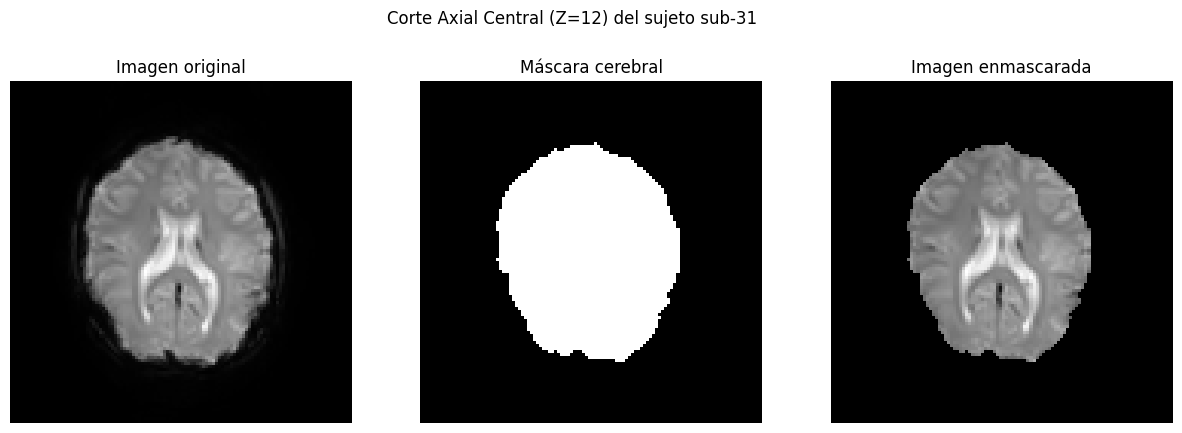

In [ ]:
subject_ids = np.load(os.path.join(base_dir, "data/splits/subject_ids_processed.npy"))
subject_id = random.choice(subject_ids)

nii_path = os.path.join(data_dir, f"{subject_id}_bold.nii.gz")
mask_path = os.path.join(save_mask_dir, f"{subject_id}_mask.npy")

visualizations_dir = os.path.join(base_dir, "data/visualizations")

img = nib.load(nii_path)
data = img.get_fdata()
mask = np.load(mask_path)

mean_vol = np.mean(data, axis=3)
masked_vol = np.where(mask, mean_vol, 0)

z = mask.shape[2] // 2
img_original = mean_vol[:, :, z].T
img_mask = mask[:, :, z].T.astype(float)
img_masked = masked_vol[:, :, z].T

plt.figure(figsize=(15, 5))
plt.suptitle(f"Corte Axial Central (Z={z}) del sujeto {subject_id}")

plt.subplot(1, 3, 1)
plt.title("Imagen original")
plt.imshow(img_original, cmap='gray', origin='lower')
plt.axis("off")
plt.savefig(os.path.join(visualizations_dir, f"{subject_id}_original.png"), bbox_inches='tight')

plt.subplot(1, 3, 2)
plt.title("Máscara cerebral")
plt.imshow(img_mask, cmap='gray', origin='lower')
plt.axis("off")
plt.savefig(os.path.join(visualizations_dir, f"{subject_id}_mask.png"), bbox_inches='tight')

plt.subplot(1, 3, 3)
plt.title("Imagen enmascarada")
plt.imshow(img_masked, cmap='gray', origin='lower')
plt.axis("off")
plt.savefig(os.path.join(visualizations_dir, f"{subject_id}_masked.png"), bbox_inches='tight')

plt.show()

## Conclusión.

El resultado es un conjunto de datos compactos y limpios que mantienen la estructura temporal e información cerebral relevante. Estos serán los datos que se utilizarán para entrenar a los modelos de *deep learning* posteriores.

## Referencias.

Avesta, A., Hossain, S., Lin, M., Aboian, M., Krumholz, H. M., & Aneja, S. (2023). Comparing 3D, 2.5 D, and 2D approaches to brain image auto-segmentation. Bioengineering, 10(2), 181. Disponible en: https://pmc.ncbi.nlm.nih.gov/articles/PMC9952534/

Bernal, J., Kushibar, K., Asfaw, D. S., Valverde, S., Oliver, A., Martí, R., & Lladó, X. (2019). Deep convolutional neural networks for brain image analysis on magnetic resonance imaging: a review. Artificial intelligence in medicine, 95, 64-81. Disponible en: https://www.sciencedirect.com/science/article/pii/S0933365716305206

Bezmaternykh, D.D., Melnikov, M.Y., Savelov, A.A., Kozlova, L.I., Petrovskiy, E.D., Natarova, K.A. and Shtark, M.B., (2021) *Brain networks connectivity in mild to moderate depression: resting state fMRI study with implications to nonpharmacological treatment*. Neural plasticity, 2021(1), p.8846097. Disponible en: https://onlinelibrary.wiley.com/doi/10.1155/2021/8846097

Jaber, H. A., Aljobouri, H. K., Çankaya, İ., Koçak, O. M., & Algin, O. (2019). Preparing fMRI data for postprocessing: Conversion modalities, preprocessing pipeline, and parametric and nonparametric approaches. IEEE Access, 7, 122864-122877. Disponible en: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8812662